In [1]:
#@title Imports
# %reset -f 

In [2]:


import numpy as np
from itertools import product as cartesian_prod

import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn import cluster

from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os
import argparse
import sys

from sklearn.svm import SVC

np.set_printoptions(precision=2)
from sklearn.neighbors import KNeighborsClassifier


In [3]:
# # Keep this commented for generating python file

# import os
# num_layers = [4]
# betas = [3]
# num_neurons = [20,50,100,200,500,1000]

# lrs =[0.001, 0.0001]

# for num_layer in num_layers:
#     for num_neuron in num_neurons:
#         for beta in betas:
#             for lr in lrs:
#                 args = ""
#                 args += " --numlayer "+str(num_layer)
#                 args += " --numnodes "+str(num_neuron)
#                 args += " --beta "+str(beta)
#                 args += " --lr "+str(lr)
#                 command = "python Decision_tree_DLGN_expts.py "+args
#                 print("=======::::::::=========:::::::::::============")
#                 print(command)
#                 os.system(command)

In [4]:
class Args:
    def __init__(self):
        self.numlayer=4
        self.numnodes=50
        self.beta=3.
        self.lr=0.001        

In [5]:



args =  Args()

num_layer = args.numlayer
num_neuron = args.numnodes
beta = args.beta
lr=args.lr

saved_epochs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,28,30,32,64,128,256,512,1024,2048, 
                4096, 8192, 16384, 32768]
filename_suffix = str(num_layer)
filename_suffix += "_"+str(num_neuron)
filename_suffix += "_"+str(int(beta))
filename_suffix += "_"+format(lr,".1e")
print(filename_suffix)


no_of_batches=10 
weight_decay=0.0
num_hidden_nodes=[num_neuron]*num_layer



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


4_50_3_1.0e-03
cpu


**Variable parameters**

In [6]:
#@title Synthetic data
def set_npseed(seed):
	np.random.seed(seed)


def set_torchseed(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

#Four mode classification data


def data_gen_decision_tree(num_data=1000, dim=2, seed=0, w_list=None, b_list=None, 
							vals=None, num_levels=2):
	'''
	Construct a complete decision tree with 2**num_levels-1 internal nodes, 
	e.g. num_levels=2 means there are 3 internal nodes.
	w_list, b_list is a list of size equal to num_internal_nodes, ie. weight and bias for each node 
	vals is a list of size equal to num_leaf_nodes, with values +1 or -1, ie. output of each leaf node
	'''
	# np.random.seed(6790)
	set_npseed(seed=seed)
	num_internal_nodes = 2**num_levels - 1
	num_leaf_nodes = 2**num_levels
	stats = np.zeros(num_internal_nodes+num_leaf_nodes)

	if vals is None:
		vals = np.arange(0,num_internal_nodes+num_leaf_nodes,1,dtype=np.int32)%2
		vals[:num_internal_nodes] = -99

	if w_list is None:
		w_list = np.random.standard_normal((num_internal_nodes, dim))
		w_list = w_list/np.linalg.norm(w_list, axis=1)[:, None]
		b_list = np.zeros((num_internal_nodes))

	data_x = np.random.random_sample((num_data, dim))*2 - 1.
	relevant_stats = data_x @ w_list.T + b_list
	
	print(relevant_stats[0,0], relevant_stats[0,1], relevant_stats[0,2])
	curr_index = np.zeros(shape=(num_data), dtype=int)
	
	for level in range(num_levels):
		nodes_curr_level=list(range(2**level - 1,2**(level+1)-1  ))
		for el in nodes_curr_level:
			b_list[el]=-1*np.median(relevant_stats[curr_index==el,el])
			relevant_stats[:,el] += b_list[el]
		decision_variable = np.choose(curr_index, relevant_stats.T) 
		# Go down and right if wx+b>0 down and left otherwise. 
		# i.e. 0 -> 1 if w[0]x+b[0]<0 and 0->2 otherwise
		curr_index = (curr_index+1)*2 - (1-(decision_variable > 0))

	bound_dist = np.min(np.abs(relevant_stats), axis=1)
	thres = 0.1
	print(relevant_stats[0,0], relevant_stats[0,1], relevant_stats[0,2])
	labels = vals[curr_index]
	data_x_pruned = data_x[bound_dist>thres]
	labels_pruned = labels[bound_dist>thres]
	relevant_stats = np.sign(data_x_pruned @ w_list.T + b_list)
	nodes_active = np.zeros((len(data_x_pruned),  num_internal_nodes+num_leaf_nodes), dtype=np.int32)
	for node in range(num_internal_nodes+num_leaf_nodes):
		if node==0:
			stats[node]=len(relevant_stats)
			nodes_active[:,0]=1
			continue
		parent = (node-1)//2
		nodes_active[:,node]=nodes_active[:,parent]
		right_child = node-(parent*2)-1 # 0 means left, 1 means right 1 has children 3,4
		if right_child==1:
			nodes_active[:,node] *= relevant_stats[:,parent]>0
		if right_child==0:
			nodes_active[:,node] *= relevant_stats[:,parent]<0		
		stats = nodes_active.sum(axis=0)
	return ((data_x_pruned, labels_pruned), (w_list, b_list, vals), stats)


# w_list = np.array([[1., 0], [0, 1], [0, 1]])
# b_list = np.array([0, 0.25, -0.25])
# vals = np.array([-99, -99, -99, 0, 1, 1, 0])
num_data = 300000
input_dim= 2 
seeds = np.random.randint(0,10000,100)
seeds=[1387]
# seeds = [2318]
for seed in seeds:
	((data_x, labels), (w_list, b_list, vals), stats) = data_gen_decision_tree(
												dim=input_dim, seed=seed, num_levels=5,
												num_data=num_data)
	seed_set=seed
w_list_old = np.array(w_list)
b_list_old = np.array(b_list)

num_data = len(data_x)
num_train= num_data//2
num_vali = num_data//4
num_test = num_data//4
train_data = data_x[:num_train,:]
train_data_labels = labels[:num_train]

vali_data = data_x[num_train:num_train+num_vali,:]
vali_data_labels = labels[num_train:num_train+num_vali]

test_data = data_x[num_train+num_vali :,:]
test_data_labels = labels[num_train+num_vali :]

-0.35700969753047973 -0.1832082080887961 -0.07225476191068489


-0.35453505927251744 -0.5251037733746184 0.3097916878813106


In [7]:
w_list[0],data_x[0],b_list[0],(w_list[0]@data_x[0]),num_data

(array([ 0.44, -0.9 ]),
 array([0.09, 1.  ]),
 0.0024746382579622804,
 -0.8565583954664894,
 8447)

In [8]:
len(vals)

63

In [9]:
def check(data_x, labels, w_list, b_list, vals):
    freq = np.zeros(len(vals))
    for i, x in enumerate(data_x):
        current_index = 1
        while current_index < 32:
            output = w_list[current_index-1]@x + b_list[current_index-1]
            current_index *= 2
            if output >= 0:
                current_index += 1
        if vals[current_index-1] == 1 and labels[i] != 1:
            return False
        if vals[current_index-1] == -1 and labels[i] != 0:
            return False
        if labels[i] == 0:
            freq[current_index-1]-=1
        else:
            freq[current_index-1]+=1
    return True, freq


In [10]:
check(data_x, labels, w_list, b_list, vals)

(True,
 array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  -290.,   122.,     0.,     0.,  -613.,     0.,
           -6.,   865.,     0.,   149.,  -444.,   135.,    -9.,     0.,
         -430.,     0.,     0.,   309., -1512.,   130.,     0.,    13.,
            0.,     0., -1323.,   264.,  -227.,  1168.,  -438.]))

In [11]:

class DLGN_FC(nn.Module):
	def __init__(self, input_dim=None, output_dim=None, num_hidden_nodes=[], beta=30, mode='pwc'):		
		super(DLGN_FC, self).__init__()
		self.num_hidden_layers = len(num_hidden_nodes)
		self.beta=beta  # Soft gating parameter
		self.mode = mode
		self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
		self.gating_layers=nn.ModuleList()
		self.value_layers=nn.ModuleList()
		
		for i in range(self.num_hidden_layers+1):
			if i!=self.num_hidden_layers:
				temp = nn.Linear(self.num_nodes[i], self.num_nodes[i+1])
				# a = temp.weight.detach() 
				# a /= a.norm(dim=1, keepdim=True)
				self.gating_layers.append(temp)
			temp = nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False)
			# a = temp.weight.detach()
			# a /= a.norm(dim=1, keepdim=True)
			self.value_layers.append(temp)


	def set_parameters_with_mask(self, to_copy, parameter_masks):
		# self and to_copy are DLGN_FC objects with same architecture
		# parameter_masks is compatible with dict(to_copy.named_parameters())
		for (name, copy_param) in to_copy.named_parameters():
			copy_param = copy_param.clone().detach()
			orig_param  = self.state_dict()[name]
			if name in parameter_masks:
				param_mask = parameter_masks[name]>0
				orig_param[param_mask] = copy_param[param_mask]
			else:
				orig_param = copy_param.data.detach()
	

								

	def return_gating_functions(self):
		effective_weights = []
		effective_biases =[]
		for i in range(self.num_hidden_layers):
			curr_weight = self.gating_layers[i].weight.detach()
			curr_bias = self.gating_layers[i].bias.detach()
			if i==0:
				effective_weights.append(curr_weight)
				effective_biases.append(curr_bias)
			else:
				effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
				effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
		return effective_weights, effective_biases
		# effective_weights (and effective biases) is a list of size num_hidden_layers
							

	def forward(self, x):
		gate_scores=[x]

		for el in self.parameters():
			if el.is_cuda:
				device = torch.device('cuda')
			else:
				device = torch.device('cpu')
		if self.mode=='pwc':
			values=[torch.ones(x.shape).to(device)]
		else:
			values=[x]
		
		for i in range(self.num_hidden_layers):
			gate_scores.append(self.gating_layers[i](gate_scores[-1]))
			curr_gate_on_off = torch.sigmoid(self.beta * gate_scores[-1])
			values.append(self.value_layers[i](values[-1])*curr_gate_on_off)
		values.append(self.value_layers[self.num_hidden_layers](values[-1]))
		# Values is a list of size 1+num_hidden_layers+1
		#gate_scores is a list of size 1+num_hidden_layers
		return values,gate_scores

In [12]:
#@title Train DLGN model
def train_dlgn (DLGN_obj, train_data_curr,vali_data_curr,test_data_curr,
				train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch=1,
				parameter_mask=dict()):
	
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	DLGN_obj.to(device)

	criterion = nn.CrossEntropyLoss()




	optimizer = optim.Adam(DLGN_obj.parameters(), lr=lr)



	train_data_torch = torch.Tensor(train_data_curr)
	vali_data_torch = torch.Tensor(vali_data_curr)
	test_data_torch = torch.Tensor(test_data_curr)

	train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
	test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
	vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)

	num_batches = no_of_batches
	batch_size = len(train_data_curr)//num_batches
	losses=[]
	DLGN_obj_store = []
	best_vali_error = len(vali_labels_curr)
	

	# print("H3")
	# print(DLGN_params)
	train_losses = []
	running_loss = 0.7*num_batches # initial random loss = 0.7 
	for epoch in tqdm(range(saved_epochs[-1])):  # loop over the dataset multiple times
		if epoch in saved_epochs:
			DLGN_obj_copy = deepcopy(DLGN_obj)
			DLGN_obj_copy.to(torch.device('cpu'))
			DLGN_obj_store.append(DLGN_obj_copy)
			train_losses.append(running_loss/num_batches)
			if running_loss/num_batches < 1e-5:
				break
		running_loss = 0.0
		for batch_start in range(0,len(train_data_curr),batch_size):
			if (batch_start+batch_size)>len(train_data_curr):
				break
			optimizer.zero_grad()
			inputs = train_data_torch[batch_start:batch_start+batch_size]
			targets = train_labels_torch[batch_start:batch_start+batch_size].reshape(batch_size)
			inputs = inputs.to(device)
			targets = targets.to(device)
			values,gate_scores = DLGN_obj(inputs)
			outputs = torch.cat((-1*values[-1], values[-1]), dim=1)
			loss = criterion(outputs, targets)			
			loss.backward()
			for name,param in DLGN_obj.named_parameters():
				parameter_mask[name] = parameter_mask[name].to(device)
				param.grad *= parameter_mask[name]   
			optimizer.step()
			running_loss += loss.item()    
		losses.append(running_loss/num_batches)
		inputs = vali_data_torch.to(device)
		targets = vali_labels_torch.to(device)
		values,gate_scores =DLGN_obj(inputs)
		vali_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
		vali_preds = torch.argmax(vali_preds, dim=1)
		vali_error= torch.sum(targets!=vali_preds)
		if vali_error < best_vali_error:
			DLGN_obj_return = deepcopy(DLGN_obj)
			best_vali_error = vali_error
	plt.figure()
	plt.title("DLGN loss vs epoch")
	plt.plot(losses)
	if not os.path.exists('figures'):
		os.mkdir('figures')

	filename = 'figures/'+filename_suffix +'.pdf'
	plt.savefig(filename)
	DLGN_obj_return.to(torch.device('cpu'))
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	return train_losses, DLGN_obj_return, DLGN_obj_store

**Training a DLGN model**

In [13]:
set_torchseed(6675)
# set_torchseed(5449)
DLGN_init= DLGN_FC(input_dim=input_dim, output_dim=1, num_hidden_nodes=num_hidden_nodes, beta=beta)


  1%|          | 256/32768 [00:06<14:36, 37.11it/s]


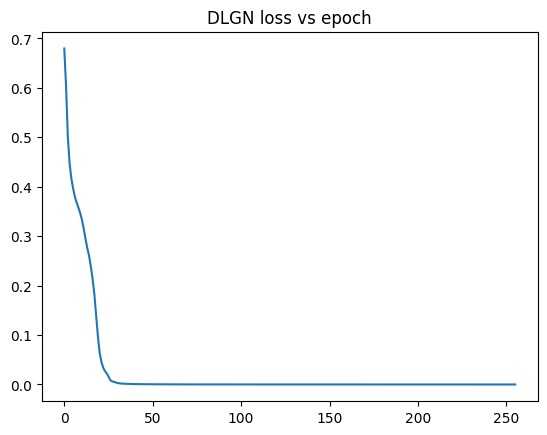

In [14]:
train_parameter_masks=dict()
for name,parameter in DLGN_init.named_parameters():
    if name[:5]=="value_"[:5]:
        train_parameter_masks[name]=torch.ones_like(parameter) # Updating all value network layers
    if name[:5]=="gating_"[:5]:
        train_parameter_masks[name]=torch.ones_like(parameter)
    train_parameter_masks[name].to(device)

set_torchseed(5000)
train_losses, DLGN_obj_final, DLGN_obj_store = train_dlgn(train_data_curr=train_data,
                                            vali_data_curr=vali_data,
                                            test_data_curr=test_data,
                                            train_labels_curr=train_data_labels,
                                            vali_labels_curr=vali_data_labels,
                                            test_labels_curr=test_data_labels,
                                            DLGN_obj=deepcopy(DLGN_init),
                                            parameter_mask=train_parameter_masks)
torch.cuda.empty_cache() 

# print(DLGN_obj_store[-1].beta)

In [15]:
if not os.path.exists('outputs'):
    os.mkdir('outputs')
# print(len(DLGN_obj_store))
# print("Hi")
device=torch.device('cpu')
train_outputs_values, train_outputs_gate_scores =DLGN_obj_final(torch.Tensor(train_data).to(device))
train_preds = train_outputs_values[-1]
criterion = nn.CrossEntropyLoss()
outputs = torch.cat((-1*train_preds,train_preds), dim=1)
targets = torch.tensor(train_data_labels, dtype=torch.int64)
train_loss = criterion(outputs, targets)
train_preds = train_preds.detach().numpy()
filename = 'outputs/'+filename_suffix+'.txt'
original_stdout = sys.stdout
with open(filename,'w') as f:
    sys.stdout = f
    print("Setup:")
    print("Num neurons : ", DLGN_obj_final.num_nodes)
    print(" Beta :", DLGN_obj_final.beta)
    print(" lr :", lr)
    print("=======================")
    print(train_losses)
    print("==========Best validated model=============")
    print("Train error=",np.sum(train_data_labels != (np.sign(train_preds[:,0])+1)//2 ))
    print("Train loss = ", train_loss)
    print("Num_train_data=",len(train_data_labels))
    sys.stdout = original_stdout


In [16]:
test_outputs_values, test_outputs_gate_scores =DLGN_obj_final(torch.Tensor(test_data))
test_preds = test_outputs_values[-1]
test_preds = test_preds.detach().numpy()
filename = 'outputs/'+filename_suffix+'.txt'
original_stdout = sys.stdout
with open(filename,'a') as f:
    sys.stdout = f
    print("Test error=",np.sum(test_data_labels != (np.sign(test_preds[:,0])+1)//2 ))
    print("Num_test_data=",len(test_data_labels))
    sys.stdout = original_stdout


In [17]:
# Learned feature statistics of best validation model

w_list = np.concatenate((w_list_old,-w_list_old),axis=0)

effective_weights, effective_biases = DLGN_obj_store[0].return_gating_functions()
wts_list_init=[]
for layer in range(0,len(effective_weights)):
    wts =  np.array(effective_weights[layer].data.detach().numpy())
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list_init.append(wts)
wts_list_init = np.concatenate(wts_list_init)


effective_weights, effective_biases = DLGN_obj_final.return_gating_functions()

wts_list=[]
for layer in range(len(effective_weights)):
    wts =  np.array(effective_weights[layer].data.detach().numpy())
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list.append(wts)
wts_list = np.concatenate(wts_list)

pd0 =  pairwise_distances(w_list,wts_list_init)
pd1 =  pairwise_distances(w_list,wts_list)


filename = 'outputs/'+filename_suffix+'.txt'
original_stdout = sys.stdout
with open(filename,'a') as f:
    sys.stdout = f
    print("Shape of decision tree node hyperplanes ", w_list.shape)
    print("Shape of all halfspace directions of DLGN", wts_list.shape)
    print("Distance of closest init DLGN halfspace to each labelling func hyperplane \n", pd0.min(axis=1)[:len(w_list_old)])
    print(pd0.min(axis=1)[len(w_list_old):])
    print("Distance of closest lrnd DLGN halfspace to each labelling func hyperplane \n", pd1.min(axis=1)[:len(w_list_old)])
    print(pd1.min(axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.8 of the Dtree hyperplanes \n", np.sum(pd1<0.8, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.8, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.6 of the Dtree hyperplanes \n", np.sum(pd1<0.6, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.6, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.4 of the Dtree hyperplanes \n", np.sum(pd1<0.4, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.4, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.3 of the Dtree hyperplanes \n", np.sum(pd1<0.3, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.3, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.2 of the Dtree hyperplanes \n", np.sum(pd1<0.2, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.2, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.1 of the Dtree hyperplanes \n", np.sum(pd1<0.1, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.1, axis=1)[len(w_list_old):])
    print("=========================================")
    sys.stdout = original_stdout




In [18]:
# Learned feature statistics of init model
epoch_index=0
effective_weights, effective_biases = DLGN_obj_store[epoch_index].return_gating_functions()
wts_list=[]
for layer in range(len(effective_weights)):
    wts =  np.array(effective_weights[layer].data.detach().numpy())
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list.append(wts)
wts_list = np.concatenate(wts_list)
pd0 =  pairwise_distances(w_list,wts_list_init)
pd1 =  pairwise_distances(w_list,wts_list)
pd_w_list = pairwise_distances(w_list, w_list)


filename = 'outputs/'+filename_suffix+'.txt'
original_stdout = sys.stdout
with open(filename,'a') as f:
    sys.stdout = f
    print("===================================")
    print("Initial epoch")
    print(epoch_index)
    print("===================================")
    train_outputs_values, train_outputs_gate_scores =DLGN_obj_store[epoch_index](torch.Tensor(train_data).to(device))
    train_preds = train_outputs_values[-1]
    criterion = nn.CrossEntropyLoss()
    outputs = torch.cat((-1*train_preds,train_preds), dim=1)
    targets = torch.tensor(train_data_labels, dtype=torch.int64)
    train_loss = criterion(outputs, targets)
    train_preds = train_preds.detach().numpy()
    test_outputs_values, test_outputs_gate_scores =DLGN_obj_store[epoch_index](torch.Tensor(test_data))
    test_preds = test_outputs_values[-1]
    test_preds = test_preds.detach().numpy()
    print("Train error=",np.sum(train_data_labels != (np.sign(train_preds[:,0])+1)//2 ))
    print("Num_train_data=",len(train_data_labels))
    print("Train loss=",train_loss.detach())
    print("Test error=",np.sum(test_data_labels != (np.sign(test_preds[:,0])+1)//2 ))
    print("Num_test_data=",len(test_data_labels))
    print("===================================")
    print("Shape of decision tree node hyperplanes ", w_list.shape)
    print("Shape of all halfspace directions of DLGN", wts_list.shape)
    print("Distance of closest init DLGN halfspace to each labelling func hyperplane \n", pd0.min(axis=1)[:len(w_list_old)])
    print(pd0.min(axis=1)[len(w_list_old):])
    print("Distance of closest lrnd DLGN halfspace to each labelling func hyperplane \n", pd1.min(axis=1)[:len(w_list_old)])
    print(pd1.min(axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.8 of the Dtree hyperplanes \n", np.sum(pd1<0.8, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.8, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.6 of the Dtree hyperplanes \n", np.sum(pd1<0.6, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.6, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.4 of the Dtree hyperplanes \n", np.sum(pd1<0.4, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.4, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.3 of the Dtree hyperplanes \n", np.sum(pd1<0.3, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.3, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.2 of the Dtree hyperplanes \n", np.sum(pd1<0.2, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.2, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.1 of the Dtree hyperplanes \n", np.sum(pd1<0.1, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.1, axis=1)[len(w_list_old):])
    print("=========================================")
    sys.stdout = original_stdout    


In [19]:
# Learned feature statistics of last iteration model
epoch_index=len(DLGN_obj_store)-1
effective_weights, effective_biases = DLGN_obj_store[epoch_index].return_gating_functions()
wts_list=[]
for layer in range(len(effective_weights)):
    wts =  np.array(effective_weights[layer].data.detach().numpy())
    wts /= np.linalg.norm(wts, axis=1)[:,None]
    wts_list.append(wts)
wts_list = np.concatenate(wts_list)

pd0 =  pairwise_distances(w_list,wts_list_init)
pd1 =  pairwise_distances(w_list,wts_list)
pd_w_list = pairwise_distances(w_list, w_list)
w_list_random = np.random.standard_normal(w_list.shape)
w_list_random /= np.linalg.norm(w_list_random, axis=1)[:,None]

pd4 = pairwise_distances(w_list_random,wts_list)


filename = 'outputs/'+filename_suffix+'.txt'
original_stdout = sys.stdout
with open(filename,'a') as f:
    sys.stdout = f
    print("===================================")
    print("last epoch: Training loss = ", train_losses[-1])
    print(epoch_index)
    print(saved_epochs[epoch_index])
    print("===================================")
    train_outputs_values, train_outputs_gate_scores =DLGN_obj_store[epoch_index](torch.Tensor(train_data).to(device))
    train_preds = train_outputs_values[-1]
    criterion = nn.CrossEntropyLoss()
    outputs = torch.cat((-1*train_preds,train_preds), dim=1)
    targets = torch.tensor(train_data_labels, dtype=torch.int64)
    train_loss = criterion(outputs, targets)
    train_preds = train_preds.detach().numpy()
    test_outputs_values, test_outputs_gate_scores =DLGN_obj_store[epoch_index](torch.Tensor(test_data))
    test_preds = test_outputs_values[-1]
    test_preds = test_preds.detach().numpy()
    print("Train error=",np.sum(train_data_labels != (np.sign(train_preds[:,0])+1)//2 ))
    print("Num_train_data=",len(train_data_labels))
    print("Train loss=",train_loss.detach())
    print("Test error=",np.sum(test_data_labels != (np.sign(test_preds[:,0])+1)//2 ))
    print("Num_test_data=",len(test_data_labels))
    print("===================================")

    print("Shape of decision tree node hyperplanes ", w_list.shape)
    print("Shape of all halfspace directions of DLGN", wts_list.shape)
    print("Distance of closest init DLGN halfspace to each labelling func hyperplane \n", pd0.min(axis=1)[:len(w_list_old)])
    print(pd0.min(axis=1)[len(w_list_old):])
    print("Distance of closest lrnd DLGN halfspace to each labelling func hyperplane \n", pd1.min(axis=1)[:len(w_list_old)])
    print(pd1.min(axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.8 of the Dtree hyperplanes \n", np.sum(pd1<0.8, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.8, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.6 of the Dtree hyperplanes \n", np.sum(pd1<0.6, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.6, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.4 of the Dtree hyperplanes \n", np.sum(pd1<0.4, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.4, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.3 of the Dtree hyperplanes \n", np.sum(pd1<0.3, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.3, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.2 of the Dtree hyperplanes \n", np.sum(pd1<0.2, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.2, axis=1)[len(w_list_old):])
    print("Number of halfspaces within distance 0.1 of the Dtree hyperplanes \n", np.sum(pd1<0.1, axis=1)[:len(w_list_old)])
    print(np.sum(pd1<0.1, axis=1)[len(w_list_old):])


    print("=========================================")
    print("No. of halfspaces within distance 0.8 of a random Dtree hyperplanes \n", np.sum(pd4<0.8, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.8, axis=1)[len(w_list_old):])
    print("No. of halfspaces within distance 0.6 of a random Dtree hyperplanes \n", np.sum(pd4<0.6, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.6, axis=1)[len(w_list_old):])
    print("No. of halfspaces within distance 0.4 of a random Dtree hyperplanes \n", np.sum(pd4<0.4, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.4, axis=1)[len(w_list_old):])
    print("No. of halfspaces within distance 0.3 of a random Dtree hyperplanes \n", np.sum(pd4<0.3, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.3, axis=1)[len(w_list_old):])
    print("No. of halfspaces within distance 0.2 of a random Dtree hyperplanes \n", np.sum(pd4<0.2, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.2, axis=1)[len(w_list_old):])
    print("No. of halfspaces within distance 0.1 of a random Dtree hyperplanes \n", np.sum(pd4<0.1, axis=1)[:len(w_list_old)])
    print(np.sum(pd4<0.1, axis=1)[len(w_list_old):])
    sys.stdout = original_stdout    


# LCN training

In [20]:
from train_utils import train, test
from network import Net 
from torch.optim.lr_scheduler import StepLR

In [29]:
model = Net(input_dim=input_dim, output_dim=2, hidden_dim=1, num_layer=12, num_back_layer=0, dense=True, drop_type='none', net_type='locally_constant', approx='interpolation').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def get_train_loader(train_data, train_data_labels, batch_size):
    # Convert data and labels to PyTorch tensors
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
    train_data_labels_tensor = torch.tensor(train_data_labels, dtype=torch.long)

    # Create a TensorDataset from the data and labels tensors
    dataset = TensorDataset(train_data_tensor, train_data_labels_tensor)

    # Create a DataLoader from the dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader
train_loader = get_train_loader(train_data, train_data_labels, batch_size=32)
valid_loader = get_train_loader(vali_data, vali_data_labels, batch_size=32)
test_loader = get_train_loader(test_data, test_data_labels, batch_size=32)

In [31]:
best_score = 100000
for epoch in range(0, 100):
        scheduler.step(epoch)

        train_approximate_loss = train(model, device, train_loader, optimizer, epoch, 'none',1)
        # used for plotting learning curves
        train_loss, train_score = test(model, device, train_loader, 'train')
        valid_loss, valid_score = test(model, device, valid_loader, 'valid')
        test_loss, test_score = test(model, device, test_loader, 'test')
        
        # early stopping version
        if valid_score > best_score:
            state = {'model': model.state_dict()}
            torch.save(state, "best_lcn.pt")
            best_score = valid_score

        # "convergent" version
        state = {'model': model.state_dict()}
        torch.save(state, "last_lcn.pt")
        print(train_loss, train_score, valid_loss, valid_score, test_loss, test_score)

0.47473191210028404 0.770068671560502 0.47368441481886175 0.7640928469919469 0.47384913377834054 0.7770941788925698
0.3987438229907047 0.8070092351408951 0.3926134513826068 0.8105163429654192 0.397744808654564 0.8092759110269758
0.3931734214708643 0.8200331517878285 0.3875286571226206 0.8195168166745618 0.39319310541464375 0.8187411263606247
0.45509998114674177 0.767700686715605 0.45448353910604283 0.7707247749881573 0.4509586978155434 0.7690487458589683
0.48221530548464253 0.7354960928250059 0.49266718688704625 0.7314069161534817 0.47727756123942217 0.7368670137245622
0.4858717644014207 0.7639119109637699 0.48627265286863497 0.7621980104216012 0.4907412958960368 0.7723615712257453
0.4660886662451825 0.751124792801326 0.4720261138742538 0.7498815727143534 0.465786929836896 0.7572172266919073
0.4600598260516836 0.7508879943168364 0.46267599361533523 0.7503552818569399 0.4594309601775854 0.7586370089919545
0.44731235944516223 0.7833293866919252 0.44321569748141654 0.7835149218379914 0.44

KeyboardInterrupt: 